In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
import math
import pprint
import seaborn

from datetime import timedelta, datetime
from copy import deepcopy, copy
from __future__ import division
from time import time
from networkx.readwrite import json_graph
from IPython.display import clear_output 
from itertools import permutations, combinations
from custom_funcs import *
from collections import Counter

%matplotlib inline

# Transmission Reconstruction

In [2]:
# Read raw data
starttime = time()
data = pd.read_csv('Raw Data/20140211 Minto and North America Combined Dates Cleaned.csv', index_col=0, parse_dates=['Collection Date'])

# Create a dictionary of accession number to strain names:
accession_to_name = dict()
for row in data.iterrows():
    accession1 = row[1]['Sequence Accession']
    accession2 = row[1]['Sequence Accession2']
    accession3 = row[1]['Sequence Accession3']
    accession4 = row[1]['Sequence Accession4']
    accession5 = row[1]['Sequence Accession5']
    accession6 = row[1]['Sequence Accession6']
    accession7 = row[1]['Sequence Accession7']
    accession8 = row[1]['Sequence Accession8']
    
    strain_name = row[1]['Strain Name']
    
    accessions = [accession1, accession2, accession3, accession4, accession5, accession6, accession7, accession8]
    
    for accession in accessions:
        accession_to_name[accession] = strain_name
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time = 1.4 seconds

Total Time: 0.918286085129 seconds


In [3]:
# For each segment, load in the PWI data, make sure the PWIs are above threshold value, and add them to a 
# dictionary of segment-specific transmission matrices.
starttime = time()

segment_affmats = dict()
segments = range(1,9)
segment_thresholds = dict()
# segment = 1

for segment in segments:
    segment_affmats[segment] = pd.read_csv('2.1 - Segment Transmission/Segment %s Transmissions.csv' % segment, index_col=['Strain Name'])
    with open('2.0 - Minimum PWI/Segment %d Minimum PWI.txt' % segment) as f:
        segment_thresholds[segment] = float(f.readlines()[0])
    segment_affmats[segment] = (segment_affmats[segment] > segment_thresholds[segment]) * segment_affmats[segment]
    columns = segment_affmats[segment].columns
#     segment_affmats[segment].columns = rename_col_or_index(columns, accession_to_name)
#     segment_affmats[segment].index = rename_col_or_index(columns, accession_to_name)

endtime = time()

print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time = 8.0 seconds

Total Time: 5.40094804764 seconds


In [4]:
for segment in segments:
    print("Segment %s threshold: %s" % (segment, segment_thresholds[segment]))

Segment 1 threshold: 0.927632
Segment 2 threshold: 0.954231
Segment 3 threshold: 0.921125
Segment 4 threshold: 0.713063
Segment 5 threshold: 0.939615
Segment 6 threshold: 0.761308
Segment 7 threshold: 0.967066
Segment 8 threshold: 0.957303


In [106]:
# Create a dictionary of segment-specific graphs.
# segment_graphs = dict()
# for segment in segments:
#     segment_graphs[segment] = nx.DiGraph()
    
starttime = time()
all_segment_transmissions = nx.DiGraph()

# First, we add in the nodes. Node data are provided in masterlist:
masterlist = pd.read_csv('Raw Data/20140211 Minto and North America Combined Dates Cleaned.csv', index_col=0, parse_dates = ['Collection Date'])
masterlist['State/Province'] = masterlist['Strain Name'].str.split('/').str[2]

# Identify names to replace:
replacement = {'BC':'British Columbia',
               'Delaware Bay': 'Delaware',
               'MB':'Manitoba',
               'Nunavet':'Nunavut',
               'SK':'Saskatchewan'}
for k, v in replacement.items():
    masterlist['State/Province'] = masterlist['State/Province'].str.replace(k, v)


# Add in the node data to each segment's graphs.
for row in masterlist.iterrows():
    all_segment_transmissions.add_node(row[1]['Strain Name'],
                                       subtype=row[1]['Subtype'],
                                       state=row[1]['Strain Name'].split("/")[2],
                                       host=row[1]['Host Species'],
                                       isolation_date=row[1]['Collection Date'])

endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time = 1.16900491714 seconds.

Total Time: 0.879108905792 seconds


In [107]:
from pprint import pprint
np.unique(masterlist['State/Province'].values)

array(['Alberta', 'Arkansas', 'British Columbia', 'California', 'Canada',
       'Delaware', 'Guatemala', 'Illinois', 'Interior Alaska', 'Iowa',
       'Louisiana', 'Maine', 'Manitoba', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'New Brunswick', 'New Jersey',
       'North Dakota', 'Nova Scotia', 'Nunavut', 'Ohio', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan',
       'Southeastern Alaska', 'Texas', 'Wisconsin'], dtype=object)

In [108]:
[edge for edge in all_segment_transmissions.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge]

[]

In [87]:
# # Create a dictionary of candidate sources. For every node, it source can occur up to 6 days after itself.

# #### NOTE: THIS IS A RULE THAT IS MINTO-FLATS CENTRIC ####
# starttime = time()
# candidate_sources = dict()
# for sink_node in all_segment_transmissions.nodes(data=True):
#     candidate_sources[sink_node[0]] = []
#     for source_node in all_segment_transmissions.nodes(data=True):
#         time_delta = sink_node[1]['collection_date'] - source_node[1]['collection_date']
#         if time_delta >= timedelta(-6) and sink_node != source_node: 
#             candidate_sources[sink_node[0]].append(source_node[0])
# endtime = time()

# print('Total Time: %s seconds' % (endtime - starttime))
# # Longest recorded time = 15 seconds

In [88]:
# The computation on a whole graph is taking excruciatingly long.
# Instead, we will go back to matrices. In this cell, compute the full transmission matrices.

starttime = time()

whole_affmat = segment_affmats[1]

for segment in segments[1:]:
    whole_affmat = whole_affmat + segment_affmats[segment]

whole_affmat = whole_affmat[whole_affmat > 7]
full_edgelist = whole_affmat.stack().dropna().reset_index()
full_edgelist.columns = ['Source', 'Sink', 'PWI']
full_edgelist = full_edgelist[full_edgelist['Source'] != full_edgelist['Sink']]

endtime = time()

print('Total Time: %s seconds' % (endtime - starttime))
# whole_affmat
# Longest recorded time = 0.336329936981 seconds

Total Time: 1.08640813828 seconds


In [89]:
# In this cell, add in the full transmission edges to the all_segment_transmissions graph. This is the first step.

starttime = time()
for row in full_edgelist.iterrows():
    source = row[1]['Source']
    sink = row[1]['Sink']
    weight = row[1]['PWI']
    segment_info = {1:None, 2:None, 3:None, 4:None, 5:None, 6:None, 7:None, 8:None}
    
    source_date = all_segment_transmissions.node[source]['isolation_date']
    sink_date = all_segment_transmissions.node[sink]['isolation_date']
    
    time_delta = sink_date - source_date
    
    all_segment_transmissions.add_edge(source, sink, segments=segment_info, weight=weight, time_delta=time_delta)
endtime = time()
print('%s seconds' % (endtime - starttime))

# Longest recorded time: 4 seconds.

3.50540280342 seconds


In [90]:
len(all_segment_transmissions.edges(data=True))

24826

In [91]:
len([edge for edge in all_segment_transmissions.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge])

126

In [92]:
# Let's now remove edges that are not informative:
starttime = time()
for edge in all_segment_transmissions.edges(data=True):
    source_date = all_segment_transmissions.node[edge[0]]['isolation_date']
    sink_date = all_segment_transmissions.node[edge[1]]['isolation_date']
    
    time_diff = sink_date - source_date
    
#     # If it is a self-looped edge, remove it.
#     if edge[0] == edge[1]:
#         all_segment_transmissions.remove_edge(edge[0], edge[1])
        
#     If it is an edge with an empty 'segments' dictionary, remove it.
#     elif len(edge[2]['segments'].keys()) == 0:
#         all_segment_transmissions.remove_edge(edge[0], edge[1])

    
    if time_diff <= timedelta(-7):
        all_segment_transmissions.remove_edge(edge[0], edge[1])

endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time: 0.25 seconds.

Total Time: 0.160706043243 seconds


In [93]:
len([edge for edge in all_segment_transmissions.edges() if 'A/mallard/Interior Alaska/10BM05860R0/2010' in edge])

83

In [94]:
len(all_segment_transmissions.edges())

18701

In [95]:
# Make a deep copy of the all_segment_transmissions graph and work only on the copy.

starttime = time()

copystart = time()
full_transmissions = all_segment_transmissions.copy()
copyend = time()
print("Prior to pruning non-full transmissions, we have %s edges" % len(full_transmissions.edges()))
print("Copying took %s seconds." % (copyend - copystart))

# Prune away any non-full edges (i.e. they do not involve all 8 segments)
for edge in full_transmissions.edges(data=True):
    if set(edge[2]['segments'].keys()) != set(segments):
        full_transmissions.remove_edge(edge[0], edge[1])
print("After pruning non-full transmissions, we have %s edges" % len(full_transmissions.edges()))

endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time: 1.36287879944 seconds.

Prior to pruning non-full transmissions, we have 18701 edges
Copying took 1.01797294617 seconds.
After pruning non-full transmissions, we have 18701 edges
Total Time: 1.08566999435 seconds


In [96]:
# Let's work through each node and figure out which is the max in_edge into it, while keeping track of which 
# edges we discarded

starttime = time()
discarded_full_transmissions = nx.DiGraph()

print('Prior to pruning non-max weight edges, we have %s edges' % len(full_transmissions.edges()))

for node in full_transmissions.nodes(data=True):
    discarded_full_transmissions.add_node(node[0], attr_dict=node[1])
    edges = full_transmissions.in_edges(node[0], data=True)
    if len(edges) > 0:
        max_weight = max([edge[2]['weight'] for edge in edges])
        for edge in edges:
            if edge[2]['weight'] < max_weight:
                full_transmissions.remove_edge(edge[0], edge[1])
                discarded_full_transmissions.add_edge(edge[0], edge[1], attr_dict=edge[2])
endtime = time()
print("After pruning non-max weight edges, we have %s edges" % len(full_transmissions.edges()))

print('Total Time: %s seconds' % (endtime - starttime))
# Last recorded time: 0.185292959213  seconds.

Prior to pruning non-max weight edges, we have 18701 edges
After pruning non-max weight edges, we have 1922 edges
Total Time: 0.201865911484 seconds


In [97]:
starttime = time()
# Find all subgraphs of G, and then add in edges that explain the earliest isolate of each subgraph.

subgraphs = list(nx.connected_component_subgraphs(full_transmissions.to_undirected()))
print("Initially, we had %s subgraphs." % len(subgraphs))

new_edges_to_add = []

for i in range(len(subgraphs)):
    earliest_nodes = find_earliest_nodes(subgraphs[i]) # Uses the custom function defined
    
    for earliest_node in earliest_nodes:

        new_edges = find_source_node(earliest_node, discarded_full_transmissions) # Uses the custom function defined
        if len(new_edges) > 0:
            new_edges_to_add.extend(new_edges)
            
full_transmissions.add_edges_from(new_edges_to_add)

print("An additional %s edges were added back as a result of finding sources for earliest isolates." % len(new_edges_to_add))
print("We now have %s edges." % len(full_transmissions.edges()))
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Last recorded time: 0.600209951401 seconds.

Initially, we had 765 subgraphs.
An additional 292 edges were added back as a result of finding sources for earliest isolates.
We now have 2214 edges.
Total Time: 0.830368995667 seconds


In [98]:
# Save the full_transmissions graph to disk
with open("3.15 - Reassortment Identification/Full Transmission Graph.pkl", 'w+') as f: 
    nx.write_gpickle(full_transmissions, f)

In [18]:
# # This cell was used for diagnostics to compare the graph from 3.15
# # to the graph from 3.10. 2 October 2014: Now that the graph has been
# # normalized, we don't need it anymore.
# # Dump the graph as a JSON node-link file.
# # Prior to doing this, serialize all of the node dates to be JSON serializable.
# full_transmissions_serialized = full_transmissions.copy()

# for node in full_transmissions_serialized.nodes(data=True):
#     node[1]['isolation_date'] = serialize_date(node[1]['isolation_date'])

# for edge in full_transmissions_serialized.edges(data=True):
#     edge[2]['time_delta'] = edge[2]['time_delta'].days
# d = json_graph.node_link_data(full_transmissions_serialized) # node-link format to serialize
# json.dump(d, open('new_graph.json','w'))

# Reassortment Finding

The next step is to do reassortment finding. To do this, we need to group the isolates by their date, and assign as a "plausible source" those isolates which are up to 6 days after the isolation date of any other given isolate.

In [19]:
# We are now to find the reassortant isolates.
starttime = time()
for edge in full_transmissions.edges(data=True):
    source = edge[0]
    sink = edge[1]
    
    for segment in edge[2]['segments'].keys():
        edge[2]['segments'][segment] = segment_affmats[segment].loc[source, sink]
        
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))

# Longest recorded time: 6 seconds.

Total Time: 3.19657301903 seconds


In [20]:
# Inspect full_transmissions edges:
# full_transmissions.edges(data=True)

In [21]:
from itertools import groupby
from datetime import datetime, timedelta

sorted_nodes = sorted(full_transmissions.nodes(data=True), key=lambda x:x[1]['isolation_date'])
items = []
for key, group in groupby(sorted_nodes, key=lambda x:x[1]['isolation_date']):
#     print(key)
    for item in group:
        items.append(item)

print("Sorted nodes is %s items long." % len(sorted_nodes))
print("Recovered nodes is %s items long." % len(items))

Sorted nodes is 1787 items long.
Recovered nodes is 1787 items long.


In [22]:
# Let's iterate over all nodes, and first pre-compute a dictionary of 
# nodes that are sink --> plausible_source by collection date time deltas.
candidate_sources = dict()
starttime = time()

for sink_node in all_segment_transmissions.nodes(data=True):
    candidate_sources[sink_node[0]] = list()
    for source_node in all_segment_transmissions.nodes(data=True):
        if sink_node[0] != source_node[0] and sink_node[1]['isolation_date'] - source_node[1]['isolation_date'] >= timedelta(-6):
            candidate_sources[sink_node[0]].append(source_node[0])
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
# Longest recorded time: 10 seconds.

Total Time: 10.6123030186 seconds


In [23]:
# From the dictionary of candidate sources, we can now filter the affinity
# matrices for every node.

starttime = time()

plausible_sources = dict()

for sink, sources in candidate_sources.items():
    plausible_sources[sink] = dict()
    
    for segment in segments:
        sources_with_pwis = segment_affmats[segment].loc[sink, sources]
        plausible_sources[sink][segment] = sources_with_pwis[sources_with_pwis > segment_thresholds[segment]]
    
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))

# Longest recorded time: 24 seconds.

Total Time: 22.3038160801 seconds


In [24]:
# Now, we need to flip the plausible_sources dictionary such that we have
# sink --> source --> (segments:PWIs).
            
starttime = time()

segment_transmissions = dict()
for sink, sources in candidate_sources.items():
    segment_transmissions[sink] = dict()
    for source in sources:
        segment_transmissions[sink][source] = dict()
        for segment in segments:
            if source in plausible_sources[sink][segment].index:
                segment_transmissions[sink][source][segment] = plausible_sources[sink][segment][source]

endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))

# Longest recorded time: 72 seconds.

Total Time: 72.5428059101 seconds


In [25]:
# How long does it take to deepcopy a dictionary in memory?
# This is purely for curiosity's sake.
starttime = time()
reassortant_transmissions = deepcopy(segment_transmissions)
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))

# Longest recorded time: 44 seconds.

Total Time: 37.8646070957 seconds


In [26]:
starttime = time()
# Now, we are going to add 
for sink in reassortant_transmissions.keys():
    for source in reassortant_transmissions[sink].keys():
        if len(reassortant_transmissions[sink][source].keys()) == 8:
            del reassortant_transmissions[sink]
            break
endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))
print("There are %s putative reassortant isolates." % len(reassortant_transmissions.keys()))
# Longest recorded time: 4 seconds.

Total Time: 0.675431966782 seconds
There are 507 putative reassortant isolates.


In [27]:
# This cell can be skilled IF and ONLY IF the source data have not changed AND you have already pickled the dictionary
# reassortant_isolates to disk.

# Otherwise, you will have to run this code, which is basically the longest part of this entire notebook.


starttime = time()

# Finally iterate over every sink-source pair, and identify pairs for 
# which the set of segments total all 8.
reassortant_isolates = dict()
for sink in reassortant_transmissions.keys():
    print("Currently at item %s of %s" % (reassortant_transmissions.keys().index(sink), len(reassortant_transmissions.keys())))    
    reassortant_isolates[sink] = dict()
    for source1, source2 in combinations(reassortant_transmissions[sink].keys(), 2):
        segs1 = reassortant_transmissions[sink][source1].keys()
        segs2 = reassortant_transmissions[sink][source2].keys()
        if set(segs1).union(segs2) == set(segments):
            source_pair = (source1, source2)
            
            reassortant_isolates[sink][source_pair] = dict()
            
            for segment in segments:
                # Segment was not donated by Source 1
                if segment not in reassortant_transmissions[sink][source1].keys():
                    reassortant_isolates[sink][source_pair][segment] = (source2, reassortant_transmissions[sink][source2][segment])

                # Segment was not donated by Source 2
                if segment not in reassortant_transmissions[sink][source2].keys():
                    reassortant_isolates[sink][source_pair][segment] = (source1, reassortant_transmissions[sink][source1][segment])

                # Segment could have been donated by Source 1 or Source 2
                if segment in reassortant_transmissions[sink][source1].keys() and segment in reassortant_transmissions[sink][source2].keys():

                    # Source 1 PWI > Source 2 PWI --> add Source 1
                    if reassortant_transmissions[sink][source1][segment] > reassortant_transmissions[sink][source2][segment]:
                        reassortant_isolates[sink][source_pair][segment] = (source1, reassortant_transmissions[sink][source1][segment])

                    # Source 1 PWI < Source 2 PWI --> add Source 2
                    if reassortant_transmissions[sink][source1][segment] < reassortant_transmissions[sink][source2][segment]:
                        reassortant_isolates[sink][source_pair][segment] = (source2, reassortant_transmissions[sink][source2][segment])

                    # Source 1 PWI == Source 2 PWI --> add source_pair, and pick source2's PWI for convenience sake.
                    if reassortant_transmissions[sink][source1][segment] == reassortant_transmissions[sink][source2][segment]:
                        reassortant_isolates[sink][source_pair][segment] = ((source_pair), reassortant_transmissions[sink][source2][segment])



endtime = time()
print('Total Time: %s seconds' % (endtime - starttime))

# Longest recorded time: 771 seconds.

Currently at item 0 of 507
Currently at item 1 of 507
Currently at item 2 of 507
Currently at item 3 of 507
Currently at item 4 of 507
Currently at item 5 of 507
Currently at item 6 of 507
Currently at item 7 of 507
Currently at item 8 of 507
Currently at item 9 of 507
Currently at item 10 of 507
Currently at item 11 of 507
Currently at item 12 of 507
Currently at item 13 of 507
Currently at item 14 of 507
Currently at item 15 of 507
Currently at item 16 of 507
Currently at item 17 of 507
Currently at item 18 of 507
Currently at item 19 of 507
Currently at item 20 of 507
Currently at item 21 of 507
Currently at item 22 of 507
Currently at item 23 of 507
Currently at item 24 of 507
Currently at item 25 of 507
Currently at item 26 of 507
Currently at item 27 of 507
Currently at item 28 of 507
Currently at item 29 of 507
Currently at item 30 of 507
Currently at item 31 of 507
Currently at item 32 of 507
Currently at item 33 of 507
Currently at item 34 of 507
Currently at item 35 of 507
Cu

In [28]:
# Compute the sum of weights for each source pair.
starttime = time()
for sink in reassortant_isolates.keys():
    for source_pair in reassortant_isolates[sink].keys():
        sum_weights = 0
        for segment in reassortant_isolates[sink][source_pair].keys():
            sum_weights += reassortant_isolates[sink][source_pair][segment][1]
            
        reassortant_isolates[sink][source_pair]['sum'] = sum_weights
        
endtime = time()
print("Total Time: %s seconds" % (endtime - starttime))

# Longest recorded time: 20 seconds.

Total Time: 17.7319231033 seconds


In [29]:
# Prune down to maximum parsimony - only most similar.
starttime = time()
for sink in reassortant_isolates.keys():
    # First off, find max weight
    max_weight = 0
    for source_pair in reassortant_isolates[sink].keys():
        if reassortant_isolates[sink][source_pair]['sum'] > max_weight: 
            max_weight = reassortant_isolates[sink][source_pair]['sum']
            
    # Then, compare every possible source pair, and delete it if sum < max_weight
    for source_pair in reassortant_isolates[sink].keys():
        if reassortant_isolates[sink][source_pair]['sum'] < max_weight:
            del reassortant_isolates[sink][source_pair]
                        
endtime = time()
print("Total Time: %s seconds" % (endtime - starttime))

Total Time: 7.07741904259 seconds


In [68]:
# Write a report of all the reassortant viruses
with open('Reassortants Identified.txt', 'w+') as f:
    for sink_isolate in reassortant_isolates.keys():
        f.write(sink_isolate + '\n')
        for source_pair, values in reassortant_isolates[sink_isolate].items():
            f.write(str(source_pair) + '\n')
            f.write(str(values) + '\n')
        
        f.write("\n")

In [72]:
# Pickle the reassortant virus dictionary to disk.
import cPickle

with open("3.15 - Reassortment Identification/Reassortant Isolates.pkl", "w+") as filename:
    cPickle.dump(reassortant_isolates, filename)

# Analysis of Reassortment

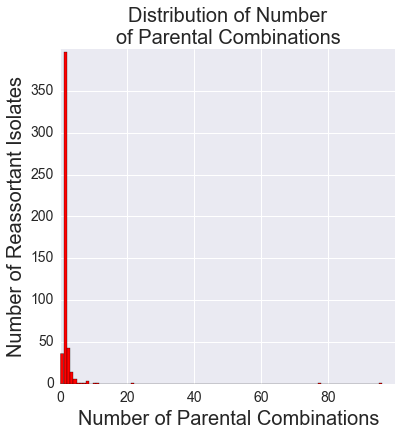

In [142]:
# Plot a histogram of the number of isolates vs. the number of parental combinations found.
length_of_sources_list = []
for sink, sources_dict in reassortant_isolates.iteritems():
    num_sources = len(sources_dict.keys())
    length_of_sources_list.append(num_sources)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.hist(length_of_sources_list, bins=100, color='Red')
# plt.ylim(0, 60)
plt.xlabel('Number of Parental Combinations', fontsize=20)
plt.ylabel('Number of Reassortant Isolates', fontsize=20)
plt.title('Distribution of Number \nof Parental Combinations', fontsize=20)
plt.yticks(range(0, 400, 50), fontsize=14)
plt.xticks(range(0,100,20), fontsize=14)
plt.savefig('3.15 - Reassortment Identification/Distribution of Number of Parental Combinations.pdf')

In [32]:
# Some properties of the histogram:
print(set(Counter(length_of_sources_list).values()))
print(sorted(set(Counter(length_of_sources_list).keys())))

set([1, 3, 36, 6, 43, 397, 14])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 22, 77, 96]


In [33]:
# Let's interrogate the reassortant_isolates dictionary. What's the strain that has 96 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 96:
        print(sink, sources_dict.keys())
        
# Note: This strain is an H3N7 virus.

('A/northern pintail/Interior Alaska/9BM11787R0/2009', [('A/northern pintail/Interior Alaska/9BM11151R0/2009', 'A/northern pintail/Interior Alaska/9BM9611R0/2009'), ('A/northern pintail/Interior Alaska/9BM10969R0/2009', 'A/northern pintail/Interior Alaska/9BM10218R0/2009'), ('A/northern pintail/Interior Alaska/9BM11779R0/2009', 'A/northern pintail/Interior Alaska/9BM10969R0/2009'), ('A/mallard/Interior Alaska/9BM3016R0/2009', 'A/northern pintail/Interior Alaska/9BM10969R0/2009'), ('A/northern pintail/Interior Alaska/9BM11179R0/2009', 'A/northern pintail/Interior Alaska/9BM9611R0/2009'), ('A/mallard/Interior Alaska/9BM3361R0/2009', 'A/northern pintail/Interior Alaska/9BM9611R0/2009'), ('A/northern pintail/Interior Alaska/9BM7840R0/2009', 'A/northern pintail/Interior Alaska/9BM10969R0/2009'), ('A/northern pintail/Interior Alaska/9BM11583R0/2009', 'A/northern pintail/Interior Alaska/9BM9611R0/2009'), ('A/northern pintail/Interior Alaska/9BM10969R0/2009', 'A/northern pintail/Interior Alask

In [34]:
# What strain has 77 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 77:
        print(sink, sources_dict.keys())
# Note: This strain has a "mixed" H3 subtype.

('A/mallard/Interior Alaska/10BM06458R0/2010', [('A/mallard/Interior Alaska/9BM8474R0/2009', 'A/mallard/Interior Alaska/10BM06461R0/2010'), ('A/northern pintail/Interior Alaska/9BM9973R0/2009', 'A/mallard/Interior Alaska/10BM06454R0/2010'), ('A/mallard/Interior Alaska/9BM9755R0/2009', 'A/mallard/Interior Alaska/10BM07777R0/2010'), ('A/mallard/Interior Alaska/9BM8474R0/2009', 'A/mallard/Interior Alaska/10BM06452R0/2010'), ('A/mallard/Interior Alaska/10BM06461R0/2010', 'A/mallard/Interior Alaska/9BM8465R0/2009'), ('A/northern pintail/Interior Alaska/9BM10146R0/2009', 'A/mallard/Interior Alaska/10BM06450R0/2010'), ('A/mallard/Interior Alaska/10BM06448R0/2010', 'A/northern pintail/Interior Alaska/9BM8448R0/2009'), ('A/northern pintail/Interior Alaska/9BM8448R0/2009', 'A/mallard/Interior Alaska/10BM06452R0/2010'), ('A/mallard/Interior Alaska/9BM9755R0/2009', 'A/mallard/Interior Alaska/10BM06448R0/2010'), ('A/northern pintail/Interior Alaska/9BM9973R0/2009', 'A/mallard/Interior Alaska/10BM06

In [35]:
# What strain has 22 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 22:
        print(sink, sources_dict.keys())
# Note: This is an H8N4 strain.

('A/northern pintail/Interior Alaska/9BM8109R0/2009', [('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern shoveler/Interior Alaska/9BM2943R1/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM4637R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM4410R1/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM6164R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM5375R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM4666R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM6165R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interior Alaska/9BM5554R0/2009'), ('A/northern pintail/Interior Alaska/9BM6510R0/2009', 'A/northern pintail/Interi

In [36]:
# What strain has 11 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 11:
        print(sink, sources_dict.keys())
# Note: This is an H3N7 strain.

('A/ruddy turnstone/New Jersey/Sg-00522/2008', [('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/ruddy turnstone/New Jersey/Sg-00517/2008'), ('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/ruddy turnstone/New Jersey/Sg-00535/2008'), ('A/ruddy turnstone/New Jersey/Sg-00504/2008', 'A/ruddy turnstone/New Jersey/Sg-00520/2008'), ('A/ruddy turnstone/New Jersey/Sg-00554/2008', 'A/ruddy turnstone/New Jersey/Sg-00520/2008'), ('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/shorebird/Delaware Bay/495/2008'), ('A/ruddy turnstone/New Jersey/Sg-00487/2008', 'A/ruddy turnstone/New Jersey/Sg-00520/2008'), ('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/ruddy turnstone/New Jersey/Sg-00498/2008'), ('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/ruddy turnstone/Delaware/Sg-00468/2008'), ('A/ruddy turnstone/New Jersey/Sg-00520/2008', 'A/ruddy turnstone/Delaware/Sg-00472/2008'), ('A/shorebird/Delaware Bay/586/2008', 'A/ruddy turnstone/New Jersey/Sg-00520/2008'), ('A/ruddy turnstone/New Jersey/Sg-

In [37]:
# What strain has 10 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 10:
        print(sink, sources_dict.keys())
# Note: This is an unknown-HA N7 strain.

('A/American green-winged teal/Interior Alaska/10BM05440R0/2010', [('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3361R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3357R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3379R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM2750R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/American green-winged teal/Interior Alaska/9BM3595R1/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3355R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3076R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3078R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/mallard/Interior Alaska/9BM3016R0/2009'), ('A/mallard/Interior Alaska/10BM05968R0/2010', 'A/northern pintail/Interior Alaska/9BM

In [38]:
# What strains have 8 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 8:
        print(sink, sources_dict.keys())
# These are what they are:
# - A/mallard/California/2552V/2011: H4N8
# - A/ruddy turnstone/Delaware/Sg-00541/2008: H4N6
# - A/ruddy turnstone/New Jersey/AI09-474/2009: H10N1

('A/mallard/California/2552V/2011', [('A/mallard/California/2563V/2011', 'A/mallard/California/2561P/2011'), ('A/mallard/California/2563V/2011', 'A/mallard/California/2549V/2011'), ('A/mallard/California/2521P/2011', 'A/mallard/California/2563V/2011'), ('A/mallard/California/2563V/2011', 'A/mallard/California/2540V/2011'), ('A/mallard/California/2563V/2011', 'A/mallard/California/2576V/2011'), ('A/mallard/California/2563V/2011', 'A/mallard/California/2569P/2011'), ('A/mallard/California/2563V/2011', 'A/mallard/California/2521V/2011'), ('A/mallard/California/2569V/2011', 'A/mallard/California/2563V/2011')])
('A/ruddy turnstone/Delaware/Sg-00541/2008', [('A/ruddy turnstone/New Jersey/Sg-00507/2008', 'A/ruddy turnstone/New Jersey/Sg-00514/2008'), ('A/shorebird/Delaware Bay/497/2008', 'A/shorebird/Delaware Bay/495/2008'), ('A/ruddy turnstone/New Jersey/Sg-00534/2008', 'A/shorebird/Delaware Bay/495/2008'), ('A/ruddy turnstone/New Jersey/Sg-00514/2008', 'A/shorebird/Delaware Bay/497/2008'), 

In [39]:
# What strains have 7 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 7:
        print(sink, sources_dict.keys())
# These are what they are:
# - A/ruddy turnstone/New Jersey/AI09-846/2009: H1N1

('A/ruddy turnstone/New Jersey/AI09-846/2009', [('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/gull/Delaware/AI09-453/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/ruddy turnstone/New Jersey/AI09-775/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/gull/Delaware/AI09-438/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/shorebird/Delaware Bay/170/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/shorebird/Delaware Bay/318/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/shorebird/Delaware Bay/321/2009'), ('A/ruddy turnstone/New Jersey/AI09-727/2009', 'A/ruddy turnstone/New Jersey/AI09-841/2009')])


In [40]:
# What strains have 6 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 6:
        print(sink, sources_dict.keys())
# These are what they are:
# - A/ruddy turnstone/New Jersey/AI09-846/2009: H6N1
# COOL - this one crosses geographic boundaries!

('A/mallard/Ohio/2043/2009', [('A/northern shoveler/California/8536/2008', 'A/ruddy turnstone/Delaware/AI09-666/2009'), ('A/ruddy turnstone/Delaware/AI09-666/2009', 'A/gadwall/California/8708/2008'), ('A/gadwall/California/8504/2008', 'A/ruddy turnstone/Delaware/AI09-666/2009'), ('A/northern pintail/California/8105/2008', 'A/ruddy turnstone/Delaware/AI09-666/2009'), ('A/northern shoveler/California/8629/2008', 'A/ruddy turnstone/Delaware/AI09-666/2009'), ('A/ruddy turnstone/Delaware/AI09-666/2009', 'A/northern shoveler/California/8528/2008')])


In [55]:
# What strains have 5 parental combinations?
for sink, sources_dict in reassortant_isolates.items():
    if len(sources_dict.keys()) == 5:
        print(sink, sources_dict.keys())
# These are what they are:
# - A/ruddy turnstone/New Jersey/AI09-846/2009: H3N8
# COOL - this one crosses geographic boundaries!
# AND - it may involve only the internal segments!

('A/mallard/Iowa/10OS2426/2010', [('A/mallard/Interior Alaska/9BM12567R0/2009', 'A/blue-winged teal/Iowa/10OS2649/2010'), ('A/northern shoveler/Interior Alaska/9BM12298R0/2009', 'A/blue-winged teal/Iowa/10OS2649/2010'), ('A/blue-winged teal/Iowa/10OS2649/2010', 'A/northern pintail/Interior Alaska/9BM10819R0/2009'), ('A/northern pintail/Interior Alaska/9BM12647R0/2009', 'A/blue-winged teal/Iowa/10OS2649/2010'), ('A/northern pintail/Interior Alaska/9BM11487R0/2009', 'A/blue-winged teal/Iowa/10OS2649/2010')])


In [42]:
# Genetic shifters are those for which the HA and NA segments come from different sources.
# Which isolates are the genetic shifters? How many source pairs suggest shift in ?

genetic_shifters = dict()

for sink, sources_dict in reassortant_isolates.items():
    genetic_shifters[sink] = 0
    for source_pair, segments_dict in sources_dict.items():
        if segments_dict[4][0] != segments_dict[6][0]:
            # This condition ensures that we do not consider those isolates for which
            # there is a possibility that both segment 4 and 6 came from the same
            # isolate.
            if len(segments_dict[4][0]) == 2 or len(segments_dict[6][0]) == 2:
                pass
            else:
                genetic_shifters[sink] += 1
                print(sink, source_pair)
     
# From the genetic_shifters dictionary, remove strains that are not deemed to be genetic shifters
for virus, count in genetic_shifters.items():
    if count == 0:
        del genetic_shifters[virus]
        
len(genetic_shifters)

('A/blue-winged teal/Missouri/10MO0011/2010', ('A/blue-winged teal/Wisconsin/2741/2009', 'A/blue-winged teal/Iowa/10OS2639/2010'))
('A/American green-winged teal/Wisconsin/2743/2009', ('A/mallard/California/5351/2009', 'A/American green-winged teal/Illinois/3054/2009'))
('A/shorebird/Delaware Bay/655/2009', ('A/ruddy turnstone/New Jersey/AI09-194/2009', 'A/ruddy turnstone/New Jersey/AI09-837/2009'))
('A/northern pintail/Interior Alaska/8BM3723/2008', ('A/mallard/Interior Alaska/8BM2102/2008', 'A/mallard/Interior Alaska/8BM3627R1/2008'))
('A/mallard/California/6768/2009', ('A/mallard/Ohio/4809-9/2008', 'A/mallard/Wisconsin/2576/2009'))
('A/blue-winged Teal/Minnesota/AI09-2977/2009', ('A/mallard/Illinois/08OS2315/2008', 'A/mallard/Minnesota/AI09-2571/2009'))
('A/northern shoveler/Mississippi/397/2010', ('A/green-winged teal/California/1841/2009', 'A/mallard/Minnesota/AI09-1684/2009'))
('A/northern shoveler/Mississippi/397/2010', ('A/mallard/Minnesota/AI09-1678/2009', 'A/green-winged teal

216

In [155]:
# How often are two segments found to be from the same source?
from collections import Counter

same_source_counts = dict()
diff_source_counts = dict()
segments = range(1,9)
for segment1 in segments:
    same_source_counts[segment1] = Counter()
    diff_source_counts[segment1] = Counter()
    for segment2 in segments:
        if segment1 != segment2:
            same_source_counts[segment1][segment2] = 0
            diff_source_counts[segment1][segment2] = 0
    
# Note: Here, we are counting any source pairs that have two sources as potentially different. 
# Consequently, we are undercounting the possibility that they have the same sources.
for sink, sources_dict in reassortant_isolates.items():
    same_source = Counter()
    diff_source = Counter()
    num_source_pairs = len(sources_dict.keys())
    
    if num_source_pairs > 0:
    
        for segment1 in segments:
            same_source[segment1] = Counter()
            diff_source[segment1] = Counter()
            for segment2 in segments:
                if segment1 != segment2:
                    same_source[segment1][segment2] = 0
                    diff_source[segment1][segment2] = 0

        for source_pair, segments_dict in sources_dict.items():
            for segment1, segment2 in permutations(segments, 2):
                if segments_dict[segment1][0] == segments_dict[segment2][0]:
                    same_source[segment1][segment2] += 1
                if (segments_dict[segment1][0] != segments_dict[segment2][0]):
                    diff_source[segment1][segment2] += 1

        # Normalize and add to master dictionary
        for segment1, segment2 in permutations(segments, 2):
            same_source_counts[segment1][segment2] += same_source[segment1][segment2] / num_source_pairs
            diff_source_counts[segment1][segment2] += diff_source[segment1][segment2] / num_source_pairs
        
same_source_counts

{1: Counter({3: 252.5, 8: 246.25, 2: 240.0, 5: 239.16666666666666, 7: 230.5, 6: 201.5, 4: 198.16666666666666}),
 2: Counter({8: 250.75, 7: 247.0, 5: 242.66666666666666, 1: 240.0, 4: 239.16666666666666, 3: 236.0, 6: 210.0}),
 3: Counter({1: 252.5, 8: 243.0, 2: 236.0, 7: 232.0, 5: 230.66666666666666, 6: 215.0, 4: 190.66666666666666}),
 4: Counter({6: 252.5, 7: 240.16666666666666, 2: 239.16666666666666, 8: 230.16666666666666, 5: 210.0, 1: 198.16666666666666, 3: 190.66666666666666}),
 5: Counter({7: 254.66666666666666, 2: 242.66666666666666, 1: 239.16666666666666, 3: 230.66666666666666, 8: 227.41666666666666, 4: 210.0, 6: 203.0}),
 6: Counter({4: 252.5, 7: 247.0, 8: 231.75, 3: 215.0, 2: 210.0, 5: 203.0, 1: 201.5}),
 7: Counter({5: 254.66666666666666, 2: 247.0, 6: 247.0, 4: 240.16666666666666, 8: 234.75, 3: 232.0, 1: 230.5}),
 8: Counter({2: 250.75, 1: 246.25, 3: 243.0, 7: 234.75, 6: 231.75, 4: 230.16666666666666, 5: 227.41666666666666})}

In [156]:
diff_source_counts

{1: Counter({4: 272.8333333333333, 6: 269.5, 7: 240.5, 5: 231.83333333333334, 2: 231.0, 8: 224.75, 3: 218.5}),
 2: Counter({6: 261.0, 3: 235.0, 4: 231.83333333333334, 1: 231.0, 5: 228.33333333333334, 7: 224.0, 8: 220.25}),
 3: Counter({4: 280.3333333333333, 6: 256.0, 5: 240.33333333333334, 7: 239.0, 2: 235.0, 8: 228.0, 1: 218.5}),
 4: Counter({3: 280.3333333333333, 1: 272.8333333333333, 5: 261.0, 8: 240.83333333333334, 2: 231.83333333333334, 7: 230.83333333333334, 6: 218.5}),
 5: Counter({6: 268.0, 4: 261.0, 8: 243.58333333333334, 3: 240.33333333333334, 1: 231.83333333333334, 2: 228.33333333333334, 7: 216.33333333333334}),
 6: Counter({1: 269.5, 5: 268.0, 2: 261.0, 3: 256.0, 8: 239.25, 7: 224.0, 4: 218.5}),
 7: Counter({1: 240.5, 3: 239.0, 8: 236.25, 4: 230.83333333333334, 2: 224.0, 6: 224.0, 5: 216.33333333333334}),
 8: Counter({5: 243.58333333333334, 4: 240.83333333333334, 6: 239.25, 7: 236.25, 3: 228.0, 1: 224.75, 2: 220.25})}

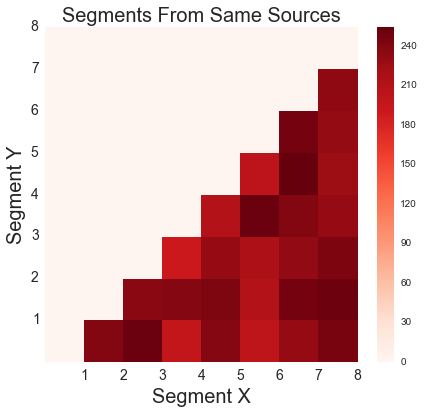

In [157]:
# Let's create a heatmap of same_source_counts 
same_source_df = pd.DataFrame(same_source_counts)
same_source_df.fillna(0, inplace=True)
same_source_df = np.triu(same_source_df.values)

diff_source_df = pd.DataFrame(diff_source_counts)
diff_source_df.fillna(0, inplace=True)

plt.figure(figsize=(7,6))
plt.pcolor(same_source_df, cmap='Reds')
plt.colorbar()
plt.xticks(range(1,9), fontsize=14)
plt.yticks(range(1,9), fontsize=14)
plt.xlabel("Segment X", fontsize=20)
plt.ylabel("Segment Y", fontsize=20)
plt.title("Segments From Same Sources", fontsize=20)
plt.savefig('3.15 - Reassortment Identification/Segments From Same Sources.pdf')

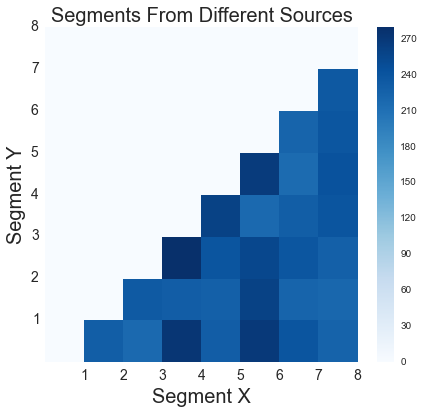

In [158]:
# Let's create a heatmap of diff_source_counts
diff_source_df = pd.DataFrame(diff_source_counts)
diff_source_df.fillna(0, inplace=True)
diff_source_df = np.triu(diff_source_df.values)

plt.figure(figsize=(7,6))
plt.pcolor(diff_source_df, cmap='Blues')
plt.colorbar()
plt.xticks(range(1,9), fontsize=14)
plt.yticks(range(1,9), fontsize=14)
plt.xlabel("Segment X", fontsize=20)
plt.ylabel("Segment Y", fontsize=20)
plt.title("Segments From Different Sources", fontsize=20)
plt.savefig('3.15 - Reassortment Identification/Segments From Different Sources.pdf')

In [47]:
# How often do we find a segment for which two sources were equally similar?
counts = 0
for sink, sources_dict in reassortant_isolates.items():
    for source_pair, segments_dict in sources_dict.items():
        for segment in segments:
            if len(segments_dict[segment][0]) == 2:
                counts += 1
                print(sink, source_pair, segment)
print(counts)

('A/shorebird/Delaware Bay/655/2009', ('A/ruddy turnstone/New Jersey/AI09-194/2009', 'A/ruddy turnstone/New Jersey/AI09-837/2009'), 5)
('A/blue-winged teal/Prince Edward Island/03910/2009', ('A/American black duck/New Brunswick/03451/2009', 'A/blue-winged teal/Prince Edward Island/03922/2009'), 5)
('A/blue-winged teal/North Dakota/Sg-00706/2008', ('A/mallard/Minnesota/Sg-00697/2008', 'A/mallard/North Dakota/Sg-00703/2008'), 7)
('A/blue-winged teal/Alberta/405/2008', ('A/mallard/Minnesota/Sg-00630/2008', 'A/mallard/Minnesota/Sg-00616/2008'), 8)
('A/American wigeon/California/6610/2008', ('A/mallard/Minnesota/Sg-00847/2008', 'A/northern pintail/Interior Alaska/8BM3736/2008'), 7)
('A/American green-winged teal/Wisconsin/08OS2270/2008', ('A/mallard/Minnesota/Sg-00949/2008', 'A/blue-winged teal/North Dakota/Sg-00719/2008'), 7)
('A/mallard/Missouri/10MO084/2010', ('A/blue-winged teal/Guatemala/CIP049-09/2010', 'A/mallard/Minnesota/Sg-00930/2008'), 7)
('A/mallard/Minnesota/Sg-00692/2008', ('A

### What is the reassortment relationship between the subtypes?

In [48]:
# Let's now create the "network" of genetically-shifted subtypes. The basic idea is this:
# 1. Every node is a subtype combination (e.g. H3N6).
# 2. If a subtype gave an HA to another subtype combination (e.g. H3N1 gave H3 to H3N6), connect H3N1 with an edge to H3N6.
# 3. Ensure that the segment # (4 or 6) is labeled on the edge.

subtype_graph = nx.DiGraph()

for isolate in genetic_shifters:
    # Get the subtype of the isolate, add to subtype_graph
    subtype = masterlist[masterlist['Strain Name'] == isolate]['Subtype'].values[0]
    subtype_graph.add_node(subtype)
        
    
    # Get the subtypes of the parental sources
    sources_dict = reassortant_isolates[isolate]
    
    for source_pair, segments_dict in sources_dict.items():
        # Make sure that the reassortant has sources
        if len(segments_dict.keys()) > 0:
            seg4source = segments_dict[4][0]
            seg6source = segments_dict[6][0]

            # Ensure that segment 4 and segment 6 came from different sources
            if seg4source != seg6source and len(seg4source) != 2 and len(seg6source) != 2:
                
                seg4source_subtype = masterlist[masterlist['Strain Name'] == seg4source]['Subtype'].values[0]
                seg6source_subtype = masterlist[masterlist['Strain Name'] == seg6source]['Subtype'].values[0]
                
                if seg4source_subtype != seg6source_subtype:

                    subtype_graph.add_edge(seg4source_subtype, subtype, segment=4)
                    subtype_graph.add_edge(seg6source_subtype, subtype, segment=6)

In [49]:
for subtype in subtype_graph.nodes(data=True):
    if len(subtype_graph.out_edges(subtype[0])) > 0:
        subtype_graph.node[subtype[0]]['outgoing'] = True
    if len(subtype_graph.out_edges(subtype[0])) == 0:
        subtype_graph.node[subtype[0]]['outgoing'] = False

    if len(subtype_graph.in_edges(subtype[0])) > 0:
        subtype_graph.node[subtype[0]]['incoming'] = True
    if len(subtype_graph.in_edges(subtype[0])) == 0:
        subtype_graph.node[subtype[0]]['incoming'] = False

subtype_graph.nodes(data=True)

[('H7N6', {'incoming': True, 'outgoing': False}),
 ('(H1)', {'incoming': True, 'outgoing': False}),
 ('(N2)', {'incoming': False, 'outgoing': True}),
 ('H10N8', {'incoming': True, 'outgoing': False}),
 ('H10N9', {'incoming': True, 'outgoing': False}),
 ('H10N1', {'incoming': True, 'outgoing': True}),
 ('H10N2', {'incoming': True, 'outgoing': False}),
 ('H10N3', {'incoming': True, 'outgoing': True}),
 ('H10N4', {'incoming': True, 'outgoing': False}),
 ('H10N5', {'incoming': True, 'outgoing': True}),
 ('H10N6', {'incoming': True, 'outgoing': True}),
 ('H10N7', {'incoming': True, 'outgoing': True}),
 ('(N3)', {'incoming': False, 'outgoing': True}),
 ('(H12)', {'incoming': False, 'outgoing': False}),
 ('H2N5', {'incoming': True, 'outgoing': True}),
 ('H2N2', {'incoming': True, 'outgoing': True}),
 ('H2N3', {'incoming': True, 'outgoing': True}),
 ('H2N9', {'incoming': True, 'outgoing': True}),
 ('H6N4', {'incoming': True, 'outgoing': False}),
 ('H1N2', {'incoming': True, 'outgoing': True}),

In [63]:
# Add the degree centrality to each of the nodes:
for node, centrality in nx.in_degree_centrality(subtype_graph).items():
    subtype_graph.node[node]['in_centrality'] = centrality
    
for node, centrality in nx.out_degree_centrality(subtype_graph).items():
    subtype_graph.node[node]['out_centrality'] = centrality
    
for node, centrality in nx.degree_centrality(subtype_graph).items():
    subtype_graph.node[node]['centrality'] = centrality

In [64]:
subtype_graph.nodes(data=True)

[('H7N6',
  {'centrality': 0.022988505747126436,
   'in_centrality': 0.022988505747126436,
   'incoming': True,
   'out_centrality': 0.0,
   'outgoing': False}),
 ('(H1)',
  {'centrality': 0.022988505747126436,
   'in_centrality': 0.022988505747126436,
   'incoming': True,
   'out_centrality': 0.0,
   'outgoing': False}),
 ('(N2)',
  {'centrality': 0.011494252873563218,
   'in_centrality': 0.0,
   'incoming': False,
   'out_centrality': 0.011494252873563218,
   'outgoing': True}),
 ('H10N8',
  {'centrality': 0.022988505747126436,
   'in_centrality': 0.022988505747126436,
   'incoming': True,
   'out_centrality': 0.0,
   'outgoing': False}),
 ('H10N9',
  {'centrality': 0.022988505747126436,
   'in_centrality': 0.022988505747126436,
   'incoming': True,
   'out_centrality': 0.0,
   'outgoing': False}),
 ('H10N1',
  {'centrality': 0.09195402298850575,
   'in_centrality': 0.04597701149425287,
   'incoming': True,
   'out_centrality': 0.04597701149425287,
   'outgoing': True}),
 ('H10N2',
 

In [65]:
# Remove any self-loops:
for edge in subtype_graph.edges(data=True):
    if edge[0] == edge[1]:
        subtype_graph.remove_edge(edge[0], edge[1])

In [66]:
# Dump graph for interactive visualization.
d = json_graph.node_link_data(subtype_graph) # node-link format to serialize
json.dump(d, open('viz/subtypenet.json','w'))

In [59]:
bcentrality = nx.betweenness_centrality(subtype_graph)
bcentrality_df = pd.DataFrame(zip(bcentrality.keys(), bcentrality.values()))
bcentrality_df.columns = ['Subtype', 'Betweenness Centrality']
bcentrality_df.sort('Betweenness Centrality', inplace=True, ascending=False)
bcentrality_df

,Subtype,Betweenness Centrality
78,H11N2,0.126431
69,H1N1,0.108671
36,H3N2,0.085608
32,H3N8,0.082600
56,H6N2,0.075075
61,H11N9,0.072588
41,H4N9,0.064026
10,H10N7,0.062639
29,H4N6,0.058831
30,H5N2,0.057675


In [60]:
nx.degree_centrality(subtype_graph)
dcentrality = pd.DataFrame(zip(nx.degree_centrality(subtype_graph).keys(), nx.degree_centrality(subtype_graph).values()))
dcentrality.columns = ['Subtype', 'Degree Centrality']
dcentrality.sort('Degree Centrality', inplace=True, ascending=False)
dcentrality

soi = 'H3N8' #subtype of interest

# set(subtype_graph.successors(soi)).difference(subtype_graph.predecessors(soi))
subtype_graph.predecessors(soi)
# subtype_graph.successors(soi)

['H4N8', 'H3N2', 'H3N7', 'H3N6']

In [61]:
dcentrality

,Subtype,Degree Centrality
32,H3N8,0.218391
69,H1N1,0.206897
56,H6N2,0.195402
10,H10N7,0.195402
29,H4N6,0.183908
36,H3N2,0.183908
30,H5N2,0.160920
78,H11N2,0.160920
61,H11N9,0.149425
17,H2N3,0.137931


In [109]:
masterlist

,Collection Date,Complete Genome,Country,Host Species,Sequence Accession,Sequence Accession2,Sequence Accession3,Sequence Accession4,Sequence Accession5,Sequence Accession6,Sequence Accession7,Sequence Accession8,State/Province,Strain Name,Subtype
0,2008-10-26,Yes,USA,IRD:American Black Duck/Avian,CY079459,CY079458,CY079457,CY079452,CY079455,CY079454,CY079453,CY079456,Illinois,A/American black duck/Illinois/08OS2688/2008,H5N2
1,2009-11-29,Yes,USA,IRD:American Black Duck/Avian,CY097541,CY097540,CY097539,CY097534,CY097537,CY097536,CY097535,CY097538,Illinois,A/American black duck/Illinois/4119/2009,H8N4
2,2010-08-08,Yes,Canada,IRD:Avian,CY138647,CY138646,CY138645,CY138640,CY138643,CY138642,CY138641,CY138644,New Brunswick,A/American black duck/New Brunswick/00321/2010,H1N1
3,2010-08-08,Yes,Canada,IRD:Avian,CY138655,CY138654,CY138653,CY138648,CY138651,CY138650,CY138649,CY138652,New Brunswick,A/American black duck/New Brunswick/00322/2010,H3N8
4,2010-08-08,Yes,Canada,IRD:Avian,CY138671,CY138670,CY138669,CY138664,CY138667,CY138666,CY138665,CY138668,New Brunswick,A/American black duck/New Brunswick/00326/2010,H1N1
5,2010-08-08,Yes,Canada,IRD:Avian,CY138679,CY138678,CY138677,CY138672,CY138675,CY138674,CY138673,CY138676,New Brunswick,A/American black duck/New Brunswick/00328/2010,H1N1
6,2010-08-08,Yes,Canada,IRD:Avian,CY138776,CY138775,CY138774,CY138769,CY138772,CY138771,CY138770,CY138773,New Brunswick,A/American black duck/New Brunswick/00344/2010,H7N7
7,2010-08-09,Yes,Canada,IRD:Avian,CY138824,CY138823,CY138822,CY138817,CY138820,CY138819,CY138818,CY138821,New Brunswick,A/American black duck/New Brunswick/00385/2010,H1N1
8,2010-08-10,Yes,Canada,IRD:Avian,CY138849,CY138848,CY138847,CY138842,CY138845,CY138844,CY138843,CY138846,New Brunswick,A/American black duck/New Brunswick/00410/2010,H1N1
9,2010-08-10,Yes,Canada,IRD:Avian,CY138857,CY138856,CY138855,CY138850,CY138853,CY138852,CY138851,CY138854,New Brunswick,A/American black duck/New Brunswick/00424/2010,H3N8


### How similar are the parental sources to the reassortant virus?

In [118]:
# Counter that holds counts of each of the four cases:
# - all three are the same
# - parents are same, differ from child.
# - child and one parent same, both different from other parent.
# - all three are different.

from collections import Counter

parent_child_species = Counter()
parent_child_state = Counter()
parent_child_year = Counter()

parent_species = Counter()
parent_state = Counter()
parent_year = Counter()

cases = ['all same', 'parents same', 'child and one parent', 'all different']

for case in cases:
    parent_child_species[case] = 0
    parent_child_state[case] = 0
    parent_child_year[case] = 0

for sink, source_pairs_dict in reassortant_isolates.items():
    sink_species = sink.split("/")[1]
    sink_state = sink.split("/")[2]
    sink_year = sink.split("/")[4]
    
    for case in cases:
        parent_species[case] = 0
        parent_state[case] = 0
        parent_year[case] = 0
    
    num_parental_pairs = len(source_pairs_dict.keys())
    
    if num_parental_pairs > 0:
        for source_pair in source_pairs_dict.keys():
            parent1 = source_pair[0].split("/")
            parent2 = source_pair[1].split("/")
            
            parent1_species = parent1[1]
            parent2_species = parent2[1]
            
            parent1_state = parent1[2]
            parent2_state = parent2[2]
            
            parent1_year=  parent1[4]
            parent2_year = parent2[4]
            
            if parent1_species == parent2_species == sink_species:
                parent_species['all same'] += 1
            if parent1_species != parent2_species and (parent1_species == sink_species or parent2_species == sink_species):
                parent_species['child and one parent'] += 1
            if parent1_species == parent2_species and (parent1_species != sink_species or parent2_species != sink_species):
                parent_species['parents same'] += 1
            if parent1_species != parent2_species and parent1_species != sink_species and parent2_species != sink_species:
                parent_species['all different'] += 1

            if parent1_state == parent2_state == sink_state:
                parent_state['all same'] += 1
            if parent1_state != parent2_state and (parent1_state == sink_state or parent2_state == sink_state):
                parent_state['child and one parent'] += 1
            if parent1_state == parent2_state and (parent1_state != sink_state or parent2_state != sink_state):
                parent_state['parents same'] += 1
            if parent1_state != parent2_state and parent1_state != sink_state and parent2_state != sink_state:
                parent_state['all different'] += 1

            
            if parent1_year == parent2_year == sink_year:
                parent_year['all same'] += 1
            if parent1_year != parent2_year and (parent1_year == sink_year or parent2_year == sink_year):
                parent_year['child and one parent'] += 1
            if parent1_year == parent2_year and (parent1_year != sink_year or parent2_year != sink_year):
                parent_year['parents same'] += 1
            if parent1_year != parent2_year and parent1_year != sink_year and parent2_year != sink_year:
                parent_year['all different'] += 1
                
        for case in cases:
            parent_species[case] = parent_species[case] / num_parental_pairs
            parent_child_species[case] += parent_species[case]

            parent_state[case] = parent_state[case] / num_parental_pairs
            parent_child_state[case] += parent_state[case]

            parent_year[case] = parent_year[case] / num_parental_pairs
            parent_child_year[case] += parent_year[case]

In [148]:
# parent_child_species
# parent_child_state
parent_child_year
sum(parent_child_species.values())

471.0

In [146]:
len(reassortant_isolates.keys())

507

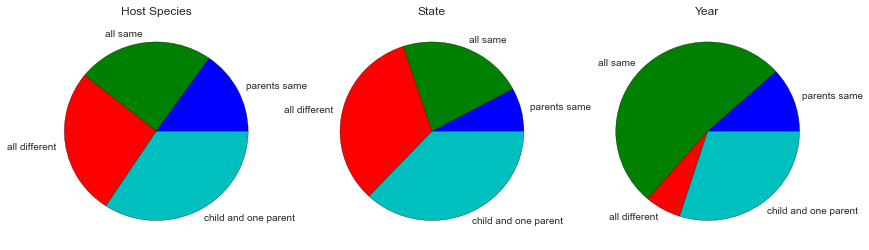

In [150]:
import seaborn

fig = plt.figure(figsize=(14, 4))
# plt.title("471 Identified Reassortant Isolates")

ax1 = fig.add_subplot(131)
ax1.pie(parent_child_species.values(), labels=parent_child_species.keys())
plt.title('Host Species')

ax2 = fig.add_subplot(132)
ax2.pie(parent_child_state.values(), labels=parent_child_state.keys())
plt.title('State')

ax3 = fig.add_subplot(133)
ax3.pie(parent_child_year.values(), labels=parent_child_year.keys())
plt.title('Year')

plt.savefig('3.15 - Reassortment Identification/Factors Influencing Viral Reassortment.pdf')